In [4]:

import os


# Verify the current directory
current_dir = os.getcwd()

# Change to the desired directory
os.chdir(f"{current_dir}/Depth-Anything-V2")

current_dir = os.getcwd()

print(f"Current directory: {current_dir}")


Current directory: /workspace/Depth-SoM/Depth-Anything-V2


In [5]:
import cv2
import numpy as np
import torch
import tempfile
from PIL import Image
from huggingface_hub import hf_hub_download
from depth_anything_v2.dpt import DepthAnythingV2
import matplotlib

class DepthContextCreator:
    def __init__(self, encoder='vitl'):
        # Set device
        self.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_configs = {
            'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
            'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
            'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
            'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
        }
        self.encoder2name = {
            'vits': 'Small',
            'vitb': 'Base',
            'vitl': 'Large',
            'vitg': 'Giant', # we are undergoing company review procedures to release our giant model checkpoint
        }
        self.encoder = encoder
        self.model_name = self.encoder2name[self.encoder]
        self.model = DepthAnythingV2(**self.model_configs[self.encoder])
        filepath = hf_hub_download(repo_id=f"depth-anything/Depth-Anything-V2-{self.model_name}", filename=f"depth_anything_v2_{self.encoder}.pth", repo_type="model")
        state_dict = torch.load(filepath, map_location="cpu",weights_only=True)
        self.model.load_state_dict(state_dict)
        self.model = self.model.to(self.DEVICE).eval()
        self.cmap = matplotlib.colormaps.get_cmap('Spectral_r')

    def predict_depth(self, image):
        return self.model.infer_image(image)

    def on_submit(self, image):
        original_image = image.copy()
        depth = self.predict_depth(image[:, :, ::-1])
        raw_depth = Image.fromarray(depth.astype('uint16'))
        tmp_raw_depth = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
        raw_depth.save(tmp_raw_depth.name)
        depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
        depth = depth.astype(np.uint8)
        colored_depth = (self.cmap(depth)[:, :, :3] * 255).astype(np.uint8)
        gray_depth = Image.fromarray(depth)
        tmp_gray_depth = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
        gray_depth.save(tmp_gray_depth.name)
        return [(original_image, colored_depth), tmp_gray_depth.name, tmp_raw_depth.name]

    def make_depth_context_img(self, image):
        image_array = np.array(image)
        print("Image loaded as NumPy array:")
        print(image_array.shape)
        all_outputs = self.on_submit(image_array)
        intensity_image = all_outputs[0][1]
        height, width, channels = image_array.shape
        flattened_intensity_image = intensity_image.reshape(-1, 3)
        intensities = np.mean(flattened_intensity_image, axis=1)
        top30_threshold = np.percentile(intensities, 70)
        bottom30_threshold = np.percentile(intensities, 30)
        top30_mask_flat = intensities > top30_threshold
        bottom30_mask_flat = intensities < bottom30_threshold
        mid40_mask_flat = (intensities >= bottom30_threshold) & (intensities <= top30_threshold)
        top30_mask = top30_mask_flat.reshape(height, width, 1)
        bottom30_mask = bottom30_mask_flat.reshape(height, width, 1)
        mid40_mask = mid40_mask_flat.reshape(height, width, 1)
        top30_image = np.where(top30_mask, image_array, 0)
        bottom30_image = np.where(bottom30_mask, image_array, 0)
        mid40_image = np.where(mid40_mask, image_array, 0)
        return [top30_image, bottom30_image, mid40_image]

import numpy as np
import matplotlib.pyplot as plt
import requests

url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTp5jMLHnfiO56w8iVWAwI4VvOu4B_5c2C1ww&s"
image = Image.open(requests.get(url, stream=True).raw)

depth_context = DepthContextCreator()
images = depth_context.make_depth_context_img(image)

plt.figure(figsize=(15, 5))
titles = ['Top 30%', 'Bottom 30%', 'Mid 40%']
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


xFormers not available
xFormers not available


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Image loaded as NumPy array:
(183, 275, 3)


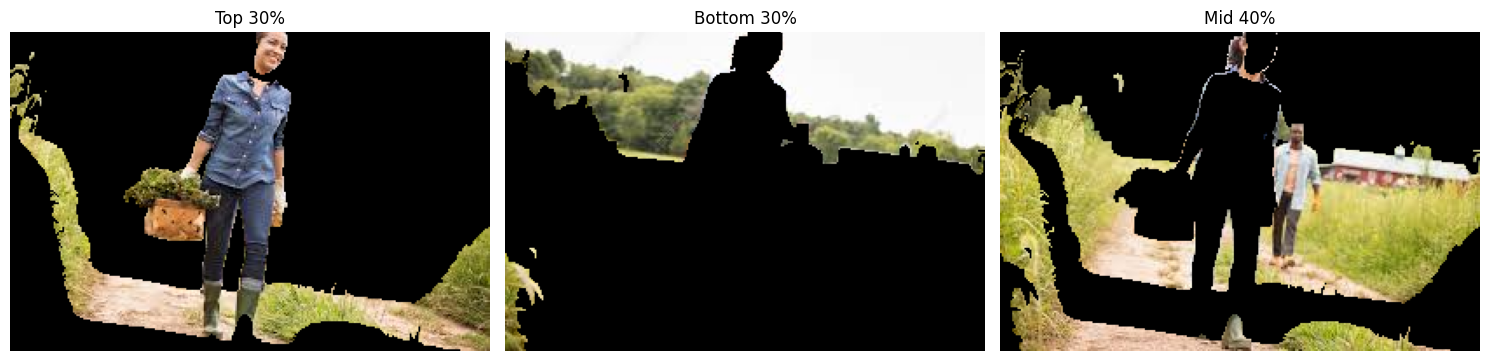

In [5]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import requests

# url = "https://depth-anything-depth-anything-v2.hf.space/file=/tmp/gradio/a467d980aa8ad4c6313e1997b850522ebd33359b/demo06.jpg"
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTp5jMLHnfiO56w8iVWAwI4VvOu4B_5c2C1ww&s"
image = Image.open(requests.get(url, stream=True).raw)
# image

def make_depth_context_img(image):
    # Convert to a NumPy array
    image_array = np.array(image)

    print("Image loaded as NumPy array:")
    print(image_array.shape)

    all_outputs = on_submit(image_array)

    # Assuming image_array is the original image array and all_outputs[0][1] contains the intensity values
    intensity_image = all_outputs[0][1]  # Image from which we calculate intensity percentiles

    # Get image dimensions
    height, width, channels = image_array.shape

    # Flatten the intensity image to get a list of all pixel intensities
    flattened_intensity_image = intensity_image.reshape(-1, 3)

    # Calculate intensity values for each pixel (using the average of RGB channels)
    intensities = np.mean(flattened_intensity_image, axis=1)

    # Calculate the percentiles
    top30_threshold = np.percentile(intensities, 70)  # 70th percentile for top 30%
    bottom30_threshold = np.percentile(intensities, 30)  # 30th percentile for bottom 30%
    
    # Create masks based on the intensity thresholds
    top30_mask_flat = intensities > top30_threshold
    bottom30_mask_flat = intensities < bottom30_threshold
    mid40_mask_flat = (intensities >= bottom30_threshold) & (intensities <= top30_threshold)

    # Reshape masks to match the original image shape (height, width, channels)
    top30_mask = top30_mask_flat.reshape(height, width, 1)
    bottom30_mask = bottom30_mask_flat.reshape(height, width, 1)
    mid40_mask = mid40_mask_flat.reshape(height, width, 1)

    # Apply masks to the image_array (preserve the regions and set others to black)
    top30_image = np.where(top30_mask, image_array, 0)
    bottom30_image = np.where(bottom30_mask, image_array, 0)
    mid40_image = np.where(mid40_mask, image_array, 0)


    return [top30_image, bottom30_image, mid40_image]



import numpy as np
import matplotlib.pyplot as plt

images = make_depth_context_img(image)

# Plot the images
plt.figure(figsize=(15, 5))
titles = ['Top 30%', 'Bottom 30%', 'Mid 40%']
# images = [top30_image, bottom30_image, mid40_image]


for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()



In [2]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq

class Kosmos2Captioner:
    def __init__(self, ckpt="microsoft/kosmos-2-patch14-224", device=None):
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
        print(f"Using device: {self.device}")
        self.processor = AutoProcessor.from_pretrained(ckpt)
        self.model = AutoModelForVision2Seq.from_pretrained(ckpt).to(self.device)

    def get_caption_and_entities(self, image_array):
        image = Image.fromarray(image_array.astype('uint8'))
        prompt = "<grounding> An image of"
        inputs = self.processor(text=prompt, images=image, return_tensors="pt").to(self.device)
        generated_ids = self.model.generate(
            pixel_values=inputs["pixel_values"],
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            image_embeds=None,
            image_embeds_position_mask=inputs["image_embeds_position_mask"],
            use_cache=True,
            max_new_tokens=128,
        )
        generated_text = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        caption, entities = self.processor.post_process_generation(generated_text)
        return caption, entities



In [3]:

# Initialize the Kosmos2Captioner
captioner = Kosmos2Captioner(device="cpu")

location = ["Closest","Mid Range","Farthest"]

for i in range(3):
    image = images[i]
    caption, entities = captioner.get_caption_and_entities(image)
    print(f"{location[i]}: {entities[0]}\n----")


Using device: cpu


NameError: name 'images' is not defined